In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Load in training dataset

In [3]:
img_dir = '../input/brain-tumor-classification-mri/Training'
test_dir = '../input/brain-tumor-classification-mri/Testing'

img_size = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
ds = tf.keras.preprocessing.image_dataset_from_directory (
    img_dir,
    shuffle = True,
    image_size= (img_size, img_size),
    batch_size = BATCH_SIZE
)

Found 2870 files belonging to 4 classes.


2022-08-20 16:51:49.967222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:51:50.084808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:51:50.085707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 16:51:50.090897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
class_names = ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [6]:
len(ds)

90

2022-08-20 16:51:52.836965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


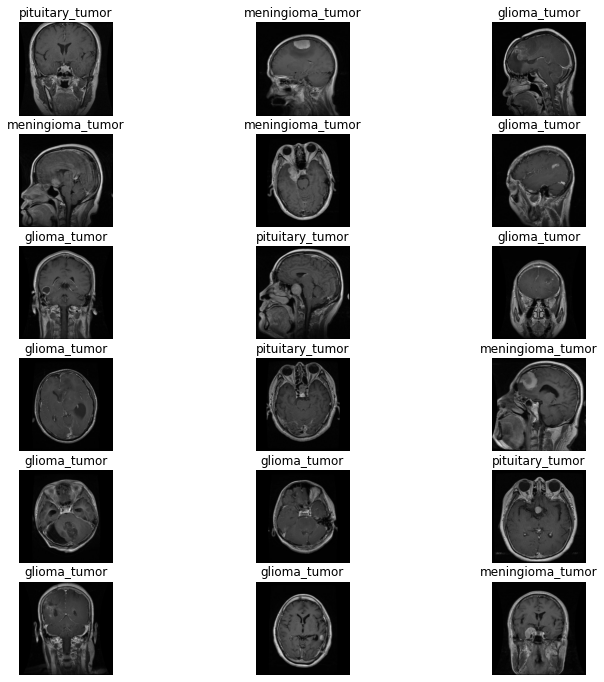

In [7]:
plt.figure(figsize = (12,12))
for image_batch, label_batch in ds.take(1):
    for i in range(18):
        ax = plt.subplot(6, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Splitting data into training, validation, and testing partitions

In [8]:
def partition_dataset(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = partition_dataset(ds)

In [10]:
len(train_ds), len(val_ds), len(test_ds)

(72, 9, 9)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Data Augmentation

In [12]:
rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

# Building The Model

In [14]:
n_classes = 4
input_shape_param = (BATCH_SIZE, img_size, img_size, CHANNELS)

model = models.Sequential([
    rescaling, 
    data_augmentation, 
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape_param),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),    
])

model.build(input_shape = input_shape_param)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [17]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/100


2022-08-20 16:52:06.742094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 80 of 10000
2022-08-20 16:52:07.061754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-08-20 16:52:07.061829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-08-20 16:52:07.086217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-08-20 16:52:08.018774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - 29s 139ms/step - loss: 1.3262 - accuracy: 0.3641 - val_loss: 1.2629 - val_accuracy: 0.4028
Epoch 2/100
72/72 [==============================] - 3s 38ms/step - loss: 1.1749 - accuracy: 0.4475 - val_loss: 1.2148 - val_accuracy: 0.3958
Epoch 3/100
72/72 [==============================] - 3s 37ms/step - loss: 1.0440 - accuracy: 0.5217 - val_loss: 0.8997 - val_accuracy: 0.6042
Epoch 4/100
72/72 [==============================] - 3s 38ms/step - loss: 0.9283 - accuracy: 0.5842 - val_loss: 0.8570 - val_accuracy: 0.6250
Epoch 5/100
72/72 [==============================] - 3s 37ms/step - loss: 0.8700 - accuracy: 0.6194 - val_loss: 0.8215 - val_accuracy: 0.6458
Epoch 6/100
72/72 [==============================] - 3s 38ms/step - loss: 0.8062 - accuracy: 0.6437 - val_loss: 0.7774 - val_accuracy: 0.6389
Epoch 7/100
72/72 [==============================] - 3s 37ms/step - loss: 0.7588 - accuracy: 0.6749 - val_loss: 0.7130 - val_accuracy: 0.7222
Epoch 8/100
72/7

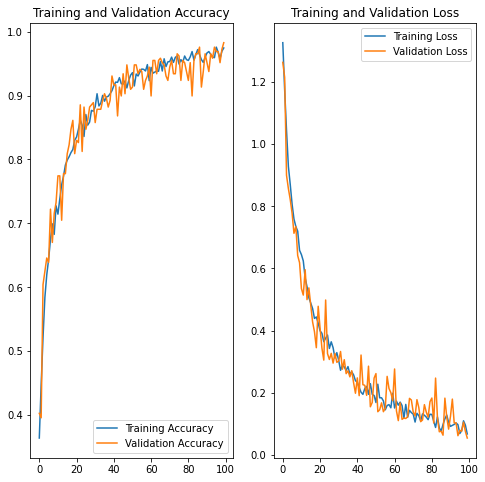

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
#model.save('./brain-cnn-model.h5')


actual label: glioma_tumor
predicted label: glioma_tumor




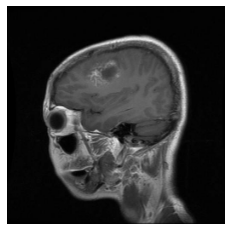

In [20]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]
    
    plt.imshow(first_image)
    plt.axis("off")
    print("\nactual label:", class_names[first_label])
    
    first_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(first_prediction[0])])
    print("\n")

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

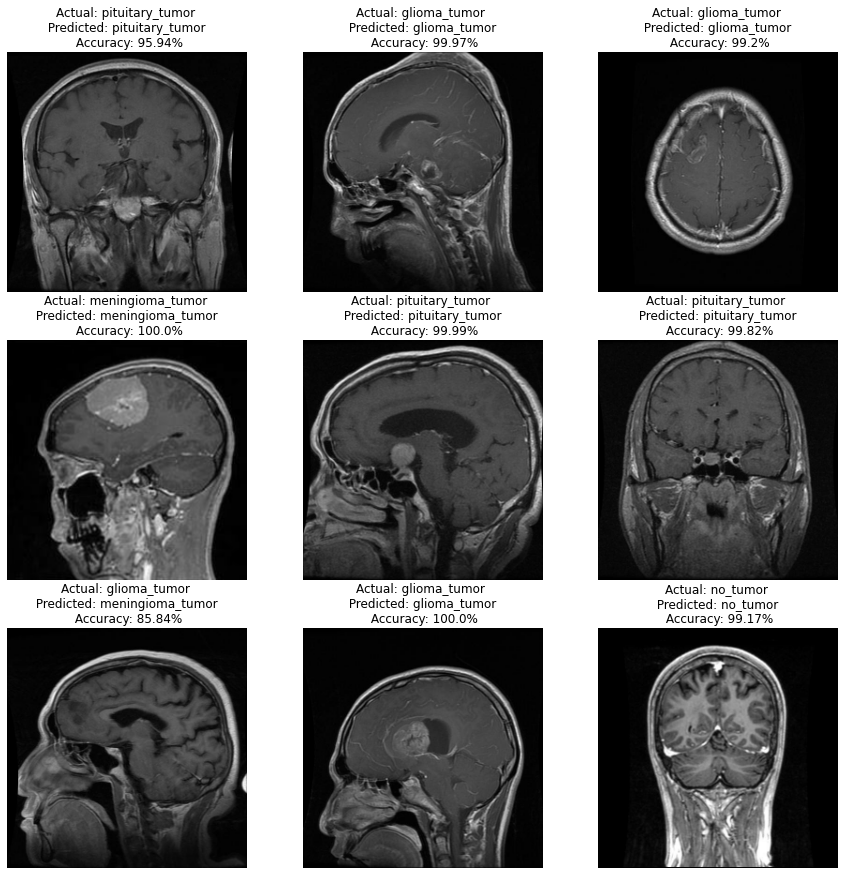

In [22]:
plt.figure(figsize = (15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Accuracy: {confidence}%")
        plt.axis("off")

# Testing the Model with a Test Directory

In [23]:
true_test_ds = tf.keras.preprocessing.image_dataset_from_directory (
    test_dir,
    shuffle = True,
    image_size= (img_size, img_size),
    batch_size = BATCH_SIZE
)

Found 394 files belonging to 4 classes.


In [24]:
test_classes = true_test_ds.class_names
test_classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

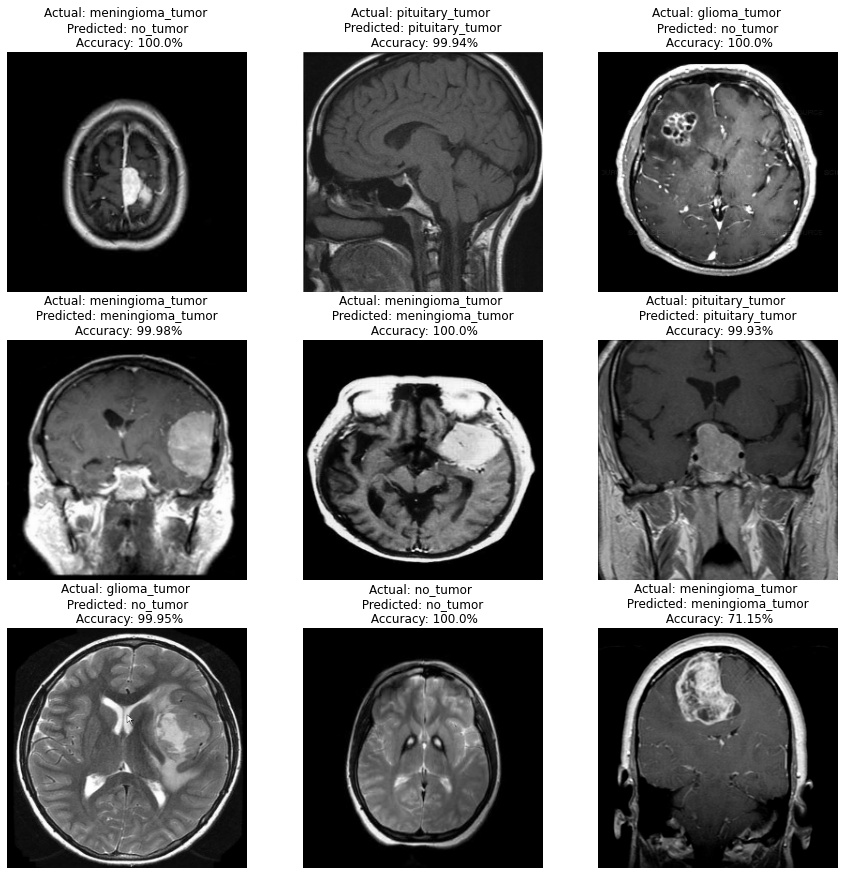

In [25]:
plt.figure(figsize = (15,15))

for images, labels in true_test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Accuracy: {confidence}%")
        plt.axis("off")

In [26]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 0s 14ms/step - loss: 0.0741 - accuracy: 0.9722


In [27]:
scores = model.evaluate(true_test_ds)

13/13 [==============================] - 1s 57ms/step - loss: 4.8774 - accuracy: 0.7183


In [28]:
len(true_test_ds)

13

In [29]:
y_pred = model.predict(true_test_ds)
y_pred

array([[6.4913244e-14, 1.0353388e-03, 9.9896467e-01, 3.5088628e-09],
       [9.5603222e-01, 3.9490789e-02, 2.9830981e-04, 4.1787066e-03],
       [7.4307984e-17, 1.0000000e+00, 1.1983660e-09, 5.5147368e-08],
       ...,
       [5.8387246e-07, 2.6412940e-07, 1.2157201e-07, 9.9999905e-01],
       [6.7641132e-02, 2.6149976e-01, 3.6585709e-10, 6.7085916e-01],
       [5.3028667e-12, 2.8566858e-06, 1.9896406e-07, 9.9999690e-01]],
      dtype=float32)

In [30]:
len(y_pred)

394

In [31]:
from sklearn.metrics import classification_report

In [32]:
for images, labels in true_test_ds.take(1):
    for i in range(32):
        
        #blind_prediction = class_names[np.argmax(y_pred[i])]
        #y_true = class_names[labels[i]]
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = test_classes[labels[i]]
        
        print(f"Actual: {actual_class}, Predicted: {predicted_class}, Accuracy: {confidence}% \n")
    

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: glioma_tumor, Predicted: meningioma_tumor, Accuracy: 99.87% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 80.37% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 100.0% 

Actual: glioma_tumor, Predicted: no_tumor, Accuracy: 99.99% 

Actual: pituitary_tumor, Predicted: pituitary_tumor, Accuracy: 100.0% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 84.45% 

Actual: pituitary_tumor, Predicted: meningioma_tumor, Accuracy: 59.62% 

Actual: glioma_tumor, Predicted: pituitary_tumor, Accuracy: 96.59% 

Actual: meningioma_tumor, Predicted: no_tumor, Accuracy: 92.39% 

Actual: glioma_tumor, Predicted: no_tumor, Accuracy: 85.16% 

Actual: pituitary_tumor, Predicted: pituitary_tumor, Accuracy: 99.97% 

Actual: glioma_tumor, Predicted: no_tumor, Accuracy: 99.99% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 100.0% 

Actual: pituitary_tumor, Predicted: me

In [34]:
for images, labels in true_test_ds.take(1):
    for i in range(32):
        
        #blind_prediction = class_names[np.argmax(y_pred[i])]
        #y_true = class_names[labels[i]]
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = test_classes[labels[i]]
        
        print(f"Actual: {actual_class}, Predicted: {predicted_class}, Accuracy: {confidence}% \n")

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 99.98% 

Actual: glioma_tumor, Predicted: no_tumor, Accuracy: 96.93% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 98.88% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 99.97% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 99.85% 

Actual: pituitary_tumor, Predicted: meningioma_tumor, Accuracy: 83.62% 

Actual: pituitary_tumor, Predicted: pituitary_tumor, Accuracy: 100.0% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: meningioma_tumor, Predicted: no_tumor, Accuracy: 99.84% 

Actual: glioma_tumor, Predicted: pituitary_tumor, Accuracy: 42.25% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 50.88% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: no_tum

In [35]:
for images, labels in test_ds.take(1):
    for i in range(32):
        
        #blind_prediction = class_names[np.argmax(y_pred[i])]
        #y_true = class_names[labels[i]]
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        print(f"Actual: {actual_class}, Predicted: {predicted_class}, Accuracy: {confidence}% \n")

Actual: glioma_tumor, Predicted: glioma_tumor, Accuracy: 100.0% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: pituitary_tumor, Predicted: pituitary_tumor, Accuracy: 100.0% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 74.09% 

Actual: glioma_tumor, Predicted: glioma_tumor, Accuracy: 99.99% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: pituitary_tumor, Predicted: pituitary_tumor, Accuracy: 100.0% 

Actual: pituitary_tumor, Predicted: pituitary_tumor, Accuracy: 100.0% 

Actual: meningioma_tumor, Predicted: meningioma_tumor, Accuracy: 98.93% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: glioma_tumor, Predicted: glioma_tumor, Accuracy: 100.0% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 90.59% 

Actual: pituitary_tumor, Predicted: pituitary_tumor, Accuracy: 100.0% 

Actual: no_tumor, Predicted: no_tumor, Accuracy: 100.0% 

Actual: glioma_tumor, Predicted: glioma_tumor, Accuracy: 99.76% 

Actual: gl

In [33]:
#classification_report(y_true, blind_prediction)